In [158]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
from IPython.display import display
from pathlib import Path
from rasterio.features import rasterize
from multiprocessing import Pool

In [159]:
class DataProcessor:
    """A class to process and visualize geospatial data from a local GeoPackage file."""

    def __init__(self, geopackage_path: str, layer_name: str, output_dir: str, code_column: str):
        """Initialize the DataProcessor with the GeoPackage details and output directory."""
        self.geopackage_path = Path(geopackage_path)
        self.layer_name = layer_name 
        self.output_dir = Path(output_dir)
        self.code_column = code_column
        if not self.geopackage_path.exists():
            raise ValueError(f"GeoPackage path {geopackage_path} does not exist.")
        self.output_dir.mkdir(parents=True, exist_ok=True)

        self.land_use_code_mapping = {
            1: [211, 212, 213, 221, 222, 223, 241, 242, 243, 244],  # agriculture
            2: [111, 112],  # urban
            3: [121, 122, 123, 124, 131, 132, 133],  # industry
            4: [523],  # water_bodies
            5: [311, 312, 313],  # nature_forest
            6: [231]  # meadow
        }
        self.category_names = {
            1: 'agriculture',
            2: 'urban',
            3: 'industry',
            4: 'water_bodies',
            5: 'nature_forest',
            6: 'meadow'
        }

    def read_data(self) -> gpd.GeoDataFrame:
        """Reads the data from the GeoPackage file."""
        data = gpd.read_file(self.geopackage_path, layer=self.layer_name)
        if data.empty:
            raise ValueError("The data is empty or not correctly loaded.")
        display(data.head())  # Display the first few rows of the data
        return data

    def reclassify_data(self, data):
        """Reclassifies the raster data into broader land use categories."""
        display("Reclassifying data")
            
        # Handle None values
        data = data.assign(**{self.code_column: data[self.code_column].fillna(-1)})
            
        codes = data[self.code_column].astype(int).values.reshape(-1, 1)  # Convert codes to integers
        reclassified = np.empty_like(codes, dtype=np.float32)

        # Create a mapping from the original codes to the new categories
        code_to_category = {code: category for category, rule_codes in self.land_use_code_mapping.items() for code in rule_codes if code != -1}
        map_func = np.vectorize(code_to_category.get, otypes=[float])
        reclassified = map_func(codes)

        display(reclassified)  # Display the reclassified data
        return reclassified, self.category_names

    def export_data(self, reclassified, data, category):
        """Exports the data of each land use type as a separate tiff file."""
        output_path = self.output_dir / f"{self.category_names[category]}.tif"
        if output_path.exists():
            display(f"File {output_path} already exists, skipping export.")
            return
        display(f"Exporting data to {output_path}")
        values = reclassified == category
        shapes = [(geom, value) for geom, value in zip(data.geometry, values)]
        rasterized = rasterize(shapes, out_shape=(data.shape[0], data.shape[1]))
        with rasterio.open(output_path, 'w', driver='GTiff', height=rasterized.shape[0],
                        width=rasterized.shape[1], count=1, dtype='float32',
                        crs='EPSG:3857') as dst:
            dst.write(rasterized.astype(rasterio.float32), 1)

    def visualize_data(self, reclassified):
        """Visualizes the reclassified data."""
        fig, ax = plt.subplots(1, 1)
        color_map = ListedColormap([
            'red',  # agriculture
            'blue',  # urban
            'darkgrey',  # industry
            'lightblue',  # water_bodies
            'green',  # nature_forest
            'yellow',  # meadow
            'white'  # other
        ])
        for category in np.unique(reclassified):
            if np.isfinite(category) and category > 0:
                ax.imshow((reclassified == category).reshape(-1, 1), cmap=color_map, alpha=0.5)
        plt.show()

    def process_data(self):
        """Main method to process the data."""
        data = self.read_data()
        reclassified, category_names = self.reclassify_data(data)
        categories = [category for category in np.unique(reclassified) if category in category_names]

        # Use a process pool to export data for each category in parallel
        with Pool() as pool:
            pool.starmap(self.export_data, [(reclassified, data, category) for category in categories])

        self.visualize_data(reclassified)

,OBJECTID,Code_18,Remark,Area_Ha,Shape_Length,Shape_Area,geometry
0,1570275,112,None,159.046461,6514.551351,1.590465e+06,"POLYGON ((468651.184 6745659.977, 468786.427 6..."
1,1570318,112,None,37.401350,3300.250382,3.740135e+05,"POLYGON ((477542.762 6749182.121, 477509.903 6..."
2,1570324,112,None,62.038357,3990.132619,6.203836e+05,"POLYGON ((455634.865 6747345.528, 455315.104 6..."
3,1570325,112,None,52.610017,3237.477859,5.261002e+05,"POLYGON ((464041.012 6749066.793, 464221.592 6..."
4,1570351,112,None,174.041492,6552.864183,1.740415e+06,"POLYGON ((494883.960 6753496.606, 494864.230 6..."


'Reclassifying data'

array([[ 2.],
       [ 2.],
       [ 2.],
       ...,
       [nan],
       [nan],
       [ 4.]])

/home/vscode/.local/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/home/vscode/.local/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


'Exporting data to corine_reclassify_GTiff/industry.tif'

'Exporting data to corine_reclassify_GTiff/water_bodies.tif'

/home/vscode/.local/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/home/vscode/.local/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


'Exporting data to corine_reclassify_GTiff/nature_forest.tif'

'Exporting data to corine_reclassify_GTiff/meadow.tif'

/home/vscode/.local/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/home/vscode/.local/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


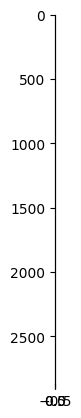

In [160]:
if __name__ == "__main__":
    processor = DataProcessor(
        geopackage_path='corine_data_landcover/zuid-holland/Results/U2018_CLC2018_V2020_20u1.gpkg',
        layer_name='U2018_CLC2018_V2020_20u1',
        output_dir='corine_reclassify_GTiff',
        code_column='Code_18'
    )
    processor.process_data()